In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data_path = '/content/drive/My Drive/AML_Assignment_2/IMDB Dataset.csv'
train=pd.read_csv(data_path)
train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
y_train = train["sentiment"].map({"negative": 0, "positive": 1})
X = train["review"]

In [5]:
X.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [6]:
stopwords_eng = set(stopwords.words("english"))
#Removing the html strips
def strip_html(text):
    p = re.compile(r'<.*?>')
    return p.sub('', text)


def clean_text(text):
    text = text.lower() # convert to lowercase
    text = strip_html(text)
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopwords_eng]
    text = " ".join(words)
    return text

X_train = X.map(clean_text)
X_train.head()

0    one reviewers mentioned watching oz episode ho...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: review, dtype: object

In [40]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(X_train)

X_train_seq = pd.Series(tokenizer.texts_to_sequences(X_train))
X_train_seq.head()


0    [3, 1897, 916, 55, 2915, 275, 3029, 98, 486, 4...
1    [271, 41, 234, 1228, 2807, 61, 6, 1999, 1430, ...
2    [89, 271, 22, 1003, 6, 725, 1317, 2429, 1088, ...
3    [550, 119, 41, 278, 3174, 1101, 850, 4036, 628...
4    [33, 6, 176, 1974, 1273, 2, 27, 314, 1414, 76,...
dtype: object

In [41]:
from keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=2000)
X_train_pad

array([[   0,    0,    0, ..., 1065, 3915,  356],
       [   0,    0,    0, ..., 1811,   12,  113],
       [   0,    0,    0, ...,   51,   11,  232],
       ...,
       [   0,    0,    0, ...,  365, 3801, 5760],
       [   0,    0,    0, ..., 1919, 3999,  595],
       [   0,    0,    0, ..., 4263,  652,    1]], dtype=int32)

In [42]:
embed_path=r'content/drive/My Drive/Clean/glove.6B.50d'

In [43]:
%cd drive/My Drive/Clean/

[Errno 2] No such file or directory: 'drive/My Drive/Clean/'
/content/drive/My Drive/Clean


In [44]:
embedding_index = {}
with open('glove.6B.50d.txt') as file: # Preparing glove
    for line in file:
        values = line.split()
        key = values[0]
        value = values[1:]
        embedding_index[key] = np.array(value, dtype='float32')
        
        
embedding_matrix = np.zeros((10000, 50)) # 10000 - num_words, 100 - length of sequence
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [45]:
import tensorflow as tf
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [47]:
model = tf.keras.models.Sequential([
    Embedding(10000, 50, input_length=2000),
    LSTM(64,dropout=0.2,),
    # Dense(32, activation=tf.nn.relu),
    Dense(1, activation=tf.nn.sigmoid),
])
model.layers[0].set_weights([embedding_matrix]) # Add glove to our model
model.layers[0].trainable = False # Freeze embedding layer

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 50)          500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 529,505
Trainable params: 29,505
Non-trainable params: 500,000
_________________________________________________________________


In [48]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=["accuracy"])

In [49]:
train_reviews=X_train_pad[:40000]
train_sentiments=y_train[:40000]
#test dataset
test_reviews=X_train_pad[40000:]
test_sentiments=y_train[40000:]

In [50]:
history=model.fit(train_reviews,train_sentiments,batch_size=32,epochs=5,verbose=2,validation_data=(test_reviews,test_sentiments))

Epoch 1/5
1250/1250 - 81s - loss: 0.4993 - accuracy: 0.7567 - val_loss: 0.4643 - val_accuracy: 0.7874
Epoch 2/5
1250/1250 - 81s - loss: 0.4157 - accuracy: 0.8108 - val_loss: 0.3733 - val_accuracy: 0.8359
Epoch 3/5
1250/1250 - 81s - loss: 0.3830 - accuracy: 0.8285 - val_loss: 0.3399 - val_accuracy: 0.8512
Epoch 4/5
1250/1250 - 81s - loss: 0.3579 - accuracy: 0.8428 - val_loss: 0.3263 - val_accuracy: 0.8607
Epoch 5/5
1250/1250 - 82s - loss: 0.3409 - accuracy: 0.8505 - val_loss: 0.3190 - val_accuracy: 0.8657


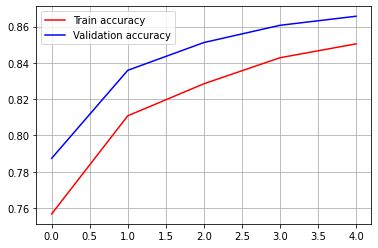

In [67]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], 'r-', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'b-', label='Validation accuracy')
plt.legend()
plt.grid()
plt.savefig("glove.jpg")
plt.show()

##Testing on the Rotten Tomatoes Dataset

In [52]:
new_data=r'/content/drive/My Drive/AML_Assignment_2/rotten_tomatoes_reviews.csv'
new=pd.read_csv(new_data)

In [53]:
X_new = new["Review"][:22500]
X_new = X_new.map(clean_text)
X_new.head()

0    manakamana answer questions yet makes point ne...
1    wilfully offensive powered chest thumping mach...
2    would difficult imagine material wrong spade l...
3    despite gusto star brings role hard ride shotg...
4    good idea core film buried unsightly pile flat...
Name: Review, dtype: object

In [54]:
X_new_seq = pd.Series(tokenizer.texts_to_sequences(X_new))
X_new_seq.head()

0    [1332, 1025, 133, 66, 111, 4, 249, 1135, 9742,...
1                     [2303, 9683, 3934, 5, 1933, 134]
2              [8, 732, 673, 681, 236, 6126, 302, 143]
3    [339, 8996, 205, 831, 108, 140, 1147, 7094, 99...
4    [5, 203, 1654, 2, 3456, 2438, 479, 642, 2299, ...
dtype: object

In [55]:
X_new_pad = pad_sequences(X_new_seq, maxlen=2000)
X_new_pad

array([[   0,    0,    0, ..., 9742,  116, 4650],
       [   0,    0,    0, ...,    5, 1933,  134],
       [   0,    0,    0, ..., 6126,  302,  143],
       ...,
       [   0,    0,    0, ...,   11,    3, 1732],
       [   0,    0,    0, ...,  101, 1953, 2871],
       [   0,    0,    0, ..., 2919,  337, 2461]], dtype=int32)

In [56]:
y_pred=model.predict(X_new_pad)

In [74]:
y_act=new['Freshness'][:22500]

Area under the Receiver Operating Characteristic curve: 0.7346678129716264


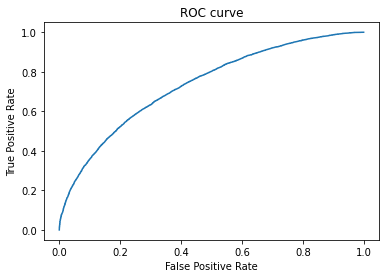

Area under the Receiver Operating Characteristic curve: 0.7346678129716264


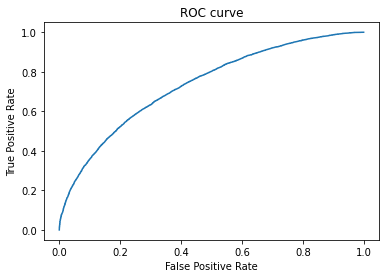

Area under the Receiver Operating Characteristic curve: 0.7346678129716264


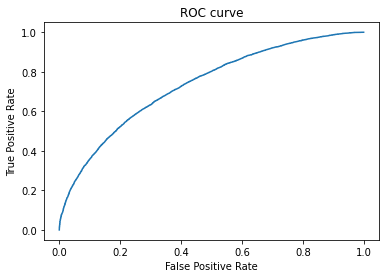

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_act, y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_act, y_pred))

In [60]:
# Importing the dependancies
from sklearn import metrics

print(metrics.confusion_matrix(y_act, y_pred.round()))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred.round()))

[[6266 5006]
 [2658 8570]]
              precision    recall  f1-score   support

           0       0.70      0.56      0.62     11272
           1       0.63      0.76      0.69     11228

    accuracy                           0.66     22500
   macro avg       0.67      0.66      0.66     22500
weighted avg       0.67      0.66      0.66     22500



In [72]:
from tensorflow.keras.metrics import Accuracy 

In [79]:
def acc(y_true, y_pred):
    return np.equal(y_true, y_pred.round()).mean()

In [81]:
loss, accuracy = model.evaluate(X_new_pad, y_act, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

704/704 [==============================] - 22s 31ms/step - loss: 0.6139 - accuracy: 0.6594
Test: accuracy = 0.659378  ;  loss = 0.613852
